# Imports

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import quantile_transform

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Dataframe Organization

### Class Information

In [23]:
# import the file
df = pd.read_csv(r"C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\descriptors.txt")

In [24]:
# Modify to extract relevant information and organize
descriptors_df = pd.DataFrame(data=None, columns=['class', 'name']) #create df with two columns
for x in range(0, 310): #iterate through 155 critical rows (somereason does each twice)
    row = [] #set appending row to zero
    temp = [str(df.iloc[x]), str(df.iloc[x+1])] #get a holder for the two values
    
    if "low" in temp[0]: #get class for first entry
        row.append("low")
    elif "high" in temp[0]:
        row.append("high")
    else:
        continue
    
    if "GSM" in temp[1]: #get GSM number from each entry, it's at a strange spot
        row.append(temp[1][temp[1].find('GSM'):temp[1].find('GSM')+10])
    
    row_dict = {'class': row[0], 'name': row[1]} #create appending dictionary
    descriptors_df = descriptors_df.append(row_dict, ignore_index=True) #append dictionary to df

In [25]:
descriptors_df.head()

,class,name
0,low,GSM1539985
1,low,GSM1539986
2,low,GSM1539987
3,low,GSM1539988
4,low,GSM1539989


In [26]:
#slight modification to index
descriptors_df = descriptors_df.set_index('name') #set name of patient as index to their status
descriptors_df.head()

,class
name,
GSM1539985,low
GSM1539986,low
GSM1539987,low
GSM1539988,low
GSM1539989,low


### Expression Information

In [27]:
#import the file
exprs_df = pd.read_csv(r"C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\NSCLC_Data", index_col="Unnamed: 0")
exprs_df.head()

,GSM1539970,GSM1539971,GSM1539972,GSM1539973,GSM1539974,GSM1539975,GSM1539976,GSM1539977,GSM1539978,GSM1539979,...,GSM1540370,GSM1540371,GSM1540372,GSM1540373,GSM1540374,GSM1540375,GSM1540376,GSM1540377,GSM1540378,GSM1540379
1007_s_at,10.464044,10.461127,10.570953,10.513374,10.516378,10.490257,10.460163,10.457428,10.504738,10.442638,...,9.988729,9.743330,9.966676,9.948810,9.972221,9.957228,9.961547,9.949829,9.841374,9.798317
1053_at,6.927708,6.645768,6.912725,6.874800,6.812996,6.777046,6.687495,6.864216,6.851013,6.785617,...,6.535750,6.546182,6.627127,6.521849,6.585274,6.639613,6.509437,6.577825,6.676129,6.230006
117_at,8.811800,8.617839,8.655456,8.733307,8.750869,8.690262,8.747771,8.715570,8.738984,8.592905,...,7.210692,7.286612,7.181658,7.268705,7.273681,7.544095,7.389453,7.037891,7.275374,7.162832
121_at,7.045294,7.174063,7.178106,7.098498,6.986867,7.214436,6.950130,7.148536,7.039930,7.182441,...,6.467075,6.386722,6.759884,6.484677,6.577028,6.440214,6.796309,6.757738,6.638337,6.756173
1255_g_at,3.719443,4.092665,3.901686,4.306990,4.036441,4.206622,4.052753,4.210017,3.934722,4.239380,...,2.940709,2.788086,2.852153,2.912606,2.886582,2.674049,3.004240,2.960987,2.970267,3.003413


### Binarize the Risk Factor

In [28]:
# reorder descriptors_df to be in same order as exprs_df
ExprsPat = exprs_df.columns
NewDesc_df = pd.DataFrame(data=None, columns=['class'])

for x in ExprsPat:
    new = descriptors_df.loc[x]
    NewDesc_df = NewDesc_df.append(new, ignore_index=False)

In [29]:
NewDesc_df.head(20)

,class
GSM1539970,high
GSM1539971,high
GSM1539972,high
GSM1539973,high
GSM1539974,high
GSM1539975,high
GSM1539976,high
GSM1539977,high
GSM1539978,high
GSM1539979,high


# Quantile Normalization

### View un-normalized data (already log2)

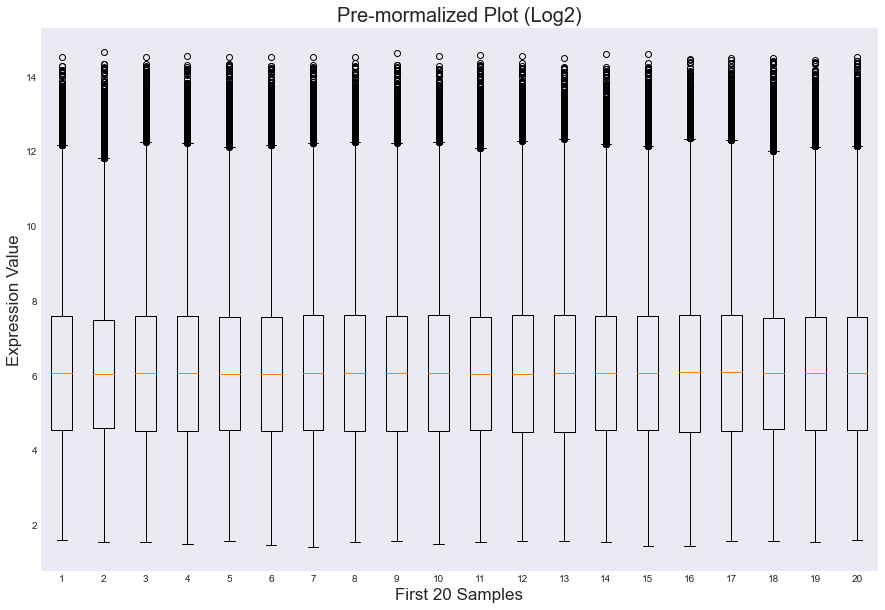

In [30]:
fig1, ax1 = plt.subplots()

ax1.set_title('Pre-mormalized Plot (Log2)', size=20)
plt.xlabel('First 20 Samples', size=17)
plt.ylabel('Expression Value', size=17)
plt.style.use('seaborn-dark')
fig1.set_size_inches(15, 10)

ax1.boxplot(exprs_df.values[:, 0:20])

# save the fig
plt.savefig(r'C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\figs\Prenormalized.png')

plt.show()

In [31]:
# download the figure

### Split the exprs_df into sample classes

In [32]:
# get number for each sample (already organized)
highPatients = []
lowPatients = []
for row in range(len(NewDesc_df.index)):
    if NewDesc_df.iloc[row, 0] == "high":
        highPatients.append(NewDesc_df.index[row])
    else:
        lowPatients.append(NewDesc_df.index[row])

In [33]:
# create respective DFs
highPDf = exprs_df.loc[:, highPatients]
lowPDf = exprs_df.loc[:, lowPatients]

In [34]:
highPDf.iloc[0:5, 0:20]

,GSM1539970,GSM1539971,GSM1539972,GSM1539973,GSM1539974,GSM1539975,GSM1539976,GSM1539977,GSM1539978,GSM1539979,GSM1539980,GSM1539981,GSM1539982,GSM1539983,GSM1539984,GSM1540255,GSM1540256,GSM1540257,GSM1540258,GSM1540259
1007_s_at,10.464044,10.461127,10.570953,10.513374,10.516378,10.490257,10.460163,10.457428,10.504738,10.442638,10.522339,10.477890,10.351924,10.455183,10.401756,9.522210,9.569496,9.537390,9.362840,9.475589
1053_at,6.927708,6.645768,6.912725,6.874800,6.812996,6.777046,6.687495,6.864216,6.851013,6.785617,6.653858,6.765689,6.868140,6.792842,6.806925,7.060326,7.137547,7.136658,7.014097,6.808532
117_at,8.811800,8.617839,8.655456,8.733307,8.750869,8.690262,8.747771,8.715570,8.738984,8.592905,8.624823,8.801170,8.881546,8.786028,8.736030,8.727704,8.993826,9.003370,8.890724,8.879042
121_at,7.045294,7.174063,7.178106,7.098498,6.986867,7.214436,6.950130,7.148536,7.039930,7.182441,7.058751,6.955452,6.890455,6.867821,7.122685,7.313521,7.175732,7.536983,7.458889,7.413865
1255_g_at,3.719443,4.092665,3.901686,4.306990,4.036441,4.206622,4.052753,4.210017,3.934722,4.239380,4.096355,3.989295,3.972844,3.923347,3.926880,3.803406,3.854921,3.770319,3.946792,3.736754


In [35]:
lowPDf.head()

,GSM1539985,GSM1539986,GSM1539987,GSM1539988,GSM1539989,GSM1539990,GSM1539991,GSM1539992,GSM1539993,GSM1539994,...,GSM1540370,GSM1540371,GSM1540372,GSM1540373,GSM1540374,GSM1540375,GSM1540376,GSM1540377,GSM1540378,GSM1540379
1007_s_at,9.785387,9.746536,9.634830,9.733948,9.669243,9.711769,9.546939,9.743483,9.737225,9.698281,...,9.988729,9.743330,9.966676,9.948810,9.972221,9.957228,9.961547,9.949829,9.841374,9.798317
1053_at,6.660023,6.780079,6.467696,6.636460,6.794087,6.693357,6.785938,6.651086,6.646408,6.710578,...,6.535750,6.546182,6.627127,6.521849,6.585274,6.639613,6.509437,6.577825,6.676129,6.230006
117_at,8.702587,8.762717,8.613793,8.658224,8.725850,8.841872,8.800744,8.544531,8.597777,8.745987,...,7.210692,7.286612,7.181658,7.268705,7.273681,7.544095,7.389453,7.037891,7.275374,7.162832
121_at,7.271974,7.073945,7.450562,7.487829,7.707573,7.496857,7.101532,7.370183,7.485641,7.309535,...,6.467075,6.386722,6.759884,6.484677,6.577028,6.440214,6.796309,6.757738,6.638337,6.756173
1255_g_at,3.740542,4.068651,3.819072,3.791752,3.892967,3.762501,3.836606,3.710910,3.644987,3.651810,...,2.940709,2.788086,2.852153,2.912606,2.886582,2.674049,3.004240,2.960987,2.970267,3.003413


### Perform Quantile Normalization

In [36]:
#quantile transform the high patient data
highNormal_exprs = quantile_transform(highPDf, random_state=100, axis=0)

# turn back into a pandas df
highNormal_exprs = pd.DataFrame(highNormal_exprs, columns=highPDf.columns)
highNormal_exprs = highNormal_exprs.set_index(highPDf.index, 'gene')

#check
highNormal_exprs.head()

C:\Users\noahb\AppData\Local\Temp/ipykernel_38572/2466850535.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  highNormal_exprs = highNormal_exprs.set_index(highPDf.index, 'gene')


,GSM1539970,GSM1539971,GSM1539972,GSM1539973,GSM1539974,GSM1539975,GSM1539976,GSM1539977,GSM1539978,GSM1539979,...,GSM1540353,GSM1540354,GSM1540355,GSM1540356,GSM1540357,GSM1540358,GSM1540359,GSM1540360,GSM1540361,GSM1540362
1007_s_at,0.974312,0.974504,0.976309,0.975302,0.974972,0.974868,0.973791,0.973563,0.974965,0.973400,...,0.974970,0.976760,0.972415,0.977060,0.973365,0.978620,0.973465,0.976857,0.974160,0.974200
1053_at,0.646020,0.613311,0.644169,0.637784,0.632770,0.624308,0.604753,0.633542,0.632711,0.621984,...,0.601667,0.581053,0.567500,0.573661,0.593308,0.594423,0.590823,0.594125,0.551085,0.599760
117_at,0.890805,0.880505,0.876701,0.884309,0.886920,0.881015,0.885007,0.881674,0.884189,0.869869,...,0.781089,0.799624,0.801028,0.811145,0.807706,0.802196,0.814827,0.805708,0.776620,0.812520
121_at,0.666318,0.703672,0.687130,0.673667,0.661394,0.695513,0.649265,0.679878,0.664799,0.685991,...,0.551061,0.589700,0.572452,0.577417,0.607567,0.505034,0.581972,0.540204,0.605387,0.624453
1255_g_at,0.152910,0.186015,0.176915,0.221855,0.189186,0.209131,0.190011,0.210115,0.178177,0.213766,...,0.232056,0.173026,0.191840,0.177383,0.151405,0.146973,0.211206,0.274104,0.186753,0.146541


In [37]:
#quantile transform the low patient data
lowNormal_exprs = quantile_transform(lowPDf, random_state=100, axis=0)

# turn back into a pandas df
lowNormal_exprs = pd.DataFrame(lowNormal_exprs, columns=lowPDf.columns)
lowNormal_exprs = lowNormal_exprs.set_index(lowPDf.index, 'gene')

#check
lowNormal_exprs.head()

C:\Users\noahb\AppData\Local\Temp/ipykernel_38572/1559482179.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  lowNormal_exprs = lowNormal_exprs.set_index(lowPDf.index, 'gene')


,GSM1539985,GSM1539986,GSM1539987,GSM1539988,GSM1539989,GSM1539990,GSM1539991,GSM1539992,GSM1539993,GSM1539994,...,GSM1540370,GSM1540371,GSM1540372,GSM1540373,GSM1540374,GSM1540375,GSM1540376,GSM1540377,GSM1540378,GSM1540379
1007_s_at,0.951703,0.950291,0.947288,0.950283,0.947307,0.949720,0.943701,0.950030,0.949946,0.948631,...,0.959416,0.950144,0.959171,0.959189,0.959916,0.958966,0.959089,0.958571,0.954269,0.954610
1053_at,0.595860,0.618208,0.572736,0.599863,0.627440,0.610743,0.625034,0.598481,0.599303,0.609946,...,0.574265,0.577950,0.594038,0.576534,0.588095,0.590770,0.575317,0.582272,0.597294,0.529933
117_at,0.881695,0.889034,0.880327,0.881825,0.886992,0.898505,0.897476,0.867187,0.873587,0.888715,...,0.682146,0.695680,0.681497,0.695015,0.696939,0.730098,0.713059,0.653777,0.692277,0.682390
121_at,0.695806,0.665587,0.736400,0.737231,0.768208,0.740182,0.678732,0.714231,0.734352,0.707107,...,0.563760,0.551677,0.614932,0.570591,0.586668,0.557445,0.621086,0.610301,0.591061,0.618236
1255_g_at,0.161449,0.194905,0.159007,0.158503,0.173132,0.156122,0.159304,0.156489,0.149358,0.146304,...,0.083451,0.069109,0.074669,0.077176,0.075409,0.058542,0.088024,0.086376,0.086927,0.086813


### Recombine the 2 DFs

In [38]:
normal_df = pd.concat([highNormal_exprs, lowNormal_exprs], axis=1)
normal_df.head()

,GSM1539970,GSM1539971,GSM1539972,GSM1539973,GSM1539974,GSM1539975,GSM1539976,GSM1539977,GSM1539978,GSM1539979,...,GSM1540370,GSM1540371,GSM1540372,GSM1540373,GSM1540374,GSM1540375,GSM1540376,GSM1540377,GSM1540378,GSM1540379
1007_s_at,0.974312,0.974504,0.976309,0.975302,0.974972,0.974868,0.973791,0.973563,0.974965,0.973400,...,0.959416,0.950144,0.959171,0.959189,0.959916,0.958966,0.959089,0.958571,0.954269,0.954610
1053_at,0.646020,0.613311,0.644169,0.637784,0.632770,0.624308,0.604753,0.633542,0.632711,0.621984,...,0.574265,0.577950,0.594038,0.576534,0.588095,0.590770,0.575317,0.582272,0.597294,0.529933
117_at,0.890805,0.880505,0.876701,0.884309,0.886920,0.881015,0.885007,0.881674,0.884189,0.869869,...,0.682146,0.695680,0.681497,0.695015,0.696939,0.730098,0.713059,0.653777,0.692277,0.682390
121_at,0.666318,0.703672,0.687130,0.673667,0.661394,0.695513,0.649265,0.679878,0.664799,0.685991,...,0.563760,0.551677,0.614932,0.570591,0.586668,0.557445,0.621086,0.610301,0.591061,0.618236
1255_g_at,0.152910,0.186015,0.176915,0.221855,0.189186,0.209131,0.190011,0.210115,0.178177,0.213766,...,0.083451,0.069109,0.074669,0.077176,0.075409,0.058542,0.088024,0.086376,0.086927,0.086813


### Generate new plot for 20 samples

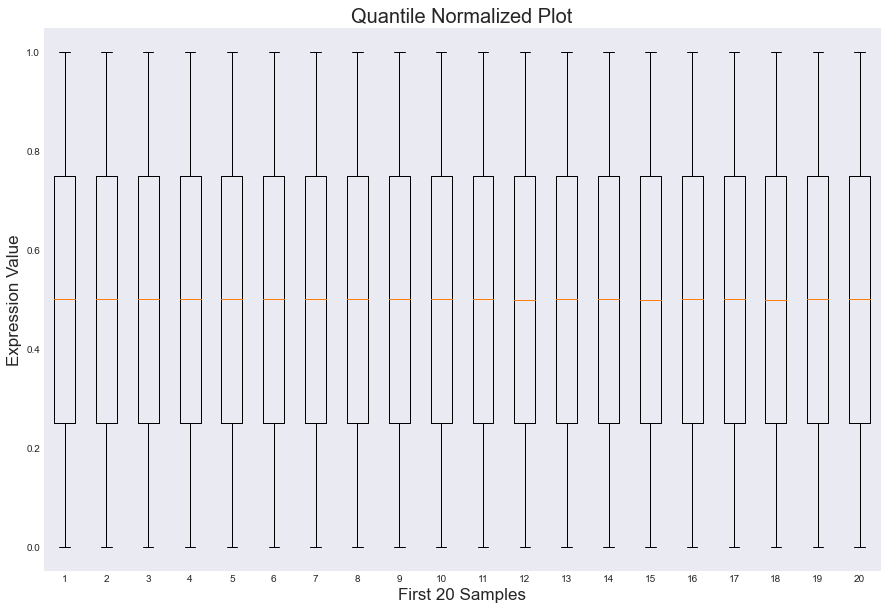

In [39]:
fig1, ax1 = plt.subplots()

ax1.set_title('Quantile Normalized Plot', size=20)
plt.xlabel('First 20 Samples', size=17)
plt.ylabel('Expression Value', size=17)
plt.style.use('seaborn-dark')
fig1.set_size_inches(15, 10)

ax1.boxplot(normal_df.values[:, 0:20])

# save the fig
plt.savefig(r'C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\figs\Normalized.png')

plt.show()

# Feature Extraction (500 Gene Symbols)

### Load the information

In [19]:
#load in top p-value genes from GEO2R data
exprs_genes = pd.read_csv(r"C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\GSE63074toptable.tsv",
                          delim_whitespace=True)
exprs_genes.head()

,ID,adj.P.Val,P.Value,t,B,logFC,Gene.symbol,Gene.title
0,237822_at,5.940000e-97,1.090000e-101,-53.180044,220.14213,-3.411071,NaN,NaN
1,240501_at,1.690000e-80,6.180000e-85,-40.764904,182.75668,-2.243506,NaN,NaN
2,214318_s_at,1.400000e-71,7.680000e-76,35.115560,162.22704,1.385832,FRY,FRYmicrotubulebindingprotein
3,233398_at,1.860000e-69,1.360000e-73,-33.818728,157.12919,-1.711378,NaN,NaN
4,201010_s_at,7.600000e-69,6.950000e-73,33.418762,155.52534,1.347150,TXNIP,thioredoxininteractingprotein


### Extract the 500 symbols and corresponding IDs

In [20]:
#pull out list of top 900 gene.symbols
check_df = pd.isnull(exprs_genes)
top_genes = []
select_ids = []
row = 0
while len(top_genes) < 500:
    if not check_df.loc[row, "Gene.symbol"]:
        top_genes.append(exprs_genes.loc[row, "Gene.symbol"])
        select_ids.append(exprs_genes.loc[row, 'ID'])
    row+=1

#verify
print(top_genes[0:10], len(top_genes))
print(select_ids[0:10])

['FRY', 'TXNIP', 'FRY', 'LRRN4', 'LRRN4', 'TXNIP', 'CENPF', 'SKP2', 'SOX2', 'EIF3B'] 500
['214318_s_at', '201010_s_at', '214319_at', '1553169_at', '1553171_x_at', '201009_s_at', '207828_s_at', '203625_x_at', '228038_at', '203462_x_at']


### Create the New DF

In [21]:
#create df of top selected values (normalized ofc)
data_df = pd.DataFrame(data=None, columns=normal_df.columns)
for row in select_ids:
    data_df = data_df.append(normal_df.loc[row, :], ignore_index=False)

data_df.head()

,GSM1539970,GSM1539971,GSM1539972,GSM1539973,GSM1539974,GSM1539975,GSM1539976,GSM1539977,GSM1539978,GSM1539979,...,GSM1540370,GSM1540371,GSM1540372,GSM1540373,GSM1540374,GSM1540375,GSM1540376,GSM1540377,GSM1540378,GSM1540379
214318_s_at,0.225009,0.175897,0.266494,0.226234,0.207195,0.224794,0.220879,0.255220,0.206237,0.244108,...,0.477786,0.442728,0.411355,0.408368,0.429466,0.395880,0.461591,0.450054,0.457013,0.425646
201010_s_at,0.981837,0.982473,0.983050,0.981403,0.983124,0.982073,0.982497,0.983385,0.982629,0.983415,...,0.996389,0.996480,0.996292,0.996212,0.996351,0.995810,0.996580,0.996421,0.996537,0.996050
214319_at,0.356847,0.390309,0.429196,0.365053,0.350972,0.381942,0.344573,0.389592,0.380559,0.440860,...,0.588580,0.576577,0.560776,0.612071,0.563093,0.594574,0.566871,0.541548,0.541018,0.537241
1553169_at,0.119188,0.172440,0.123880,0.114260,0.153713,0.121863,0.116463,0.139033,0.114654,0.113826,...,0.412711,0.464889,0.435809,0.453764,0.479009,0.501447,0.500031,0.537895,0.480986,0.495147
1553171_x_at,0.092092,0.101269,0.082254,0.110006,0.155114,0.083550,0.128850,0.121121,0.099764,0.073315,...,0.454454,0.468468,0.460665,0.466387,0.542377,0.500926,0.518244,0.563022,0.502144,0.481200


In [22]:
#check shape
print(data_df.shape)

(500, 155)


# Transpose the Matrix and Add Class

### Transpose the Matrix

In [23]:
#transpose the matrix
final_mat = data_df.T
final_mat.head()

,214318_s_at,201010_s_at,214319_at,1553169_at,1553171_x_at,201009_s_at,207828_s_at,203625_x_at,228038_at,203462_x_at,...,242546_at,1553348_a_at,212320_at,227526_at,225669_at,1558793_at,216321_s_at,225395_s_at,206373_at,211890_x_at
GSM1539970,0.225009,0.981837,0.356847,0.119188,0.092092,0.953103,0.931396,0.919823,0.935285,0.943560,...,0.942190,0.698719,0.979799,0.303445,0.677447,0.052209,0.882156,0.783035,0.453934,0.615474
GSM1539971,0.175897,0.982473,0.390309,0.172440,0.101269,0.949333,0.924008,0.911031,0.937842,0.943432,...,0.941669,0.712845,0.983358,0.284206,0.685583,0.049485,0.873557,0.782175,0.372680,0.611744
GSM1539972,0.266494,0.983050,0.429196,0.123880,0.082254,0.944757,0.915266,0.906183,0.931640,0.942690,...,0.942730,0.710046,0.984323,0.355480,0.707445,0.030823,0.879643,0.774108,0.423423,0.589647
GSM1539973,0.226234,0.981403,0.365053,0.114260,0.110006,0.949255,0.919211,0.913026,0.941322,0.942762,...,0.947132,0.705206,0.979005,0.358699,0.700315,0.060693,0.886725,0.778150,0.425083,0.635364
GSM1539974,0.207195,0.983124,0.350972,0.153713,0.155114,0.947540,0.929621,0.909739,0.942415,0.942343,...,0.948879,0.700715,0.985503,0.311898,0.677677,0.055289,0.879780,0.787725,0.367273,0.638757


### Get ordered class of patients and append column

In [24]:
# testing outcomes HERE
# reorder descriptors_df to be in same order as exprs_df
ExprsPat = final_mat.index
NewDesc_df = pd.DataFrame(data=None, columns=['class'])

for x in ExprsPat:
    new = descriptors_df.loc[x]
    NewDesc_df = NewDesc_df.append(new, ignore_index=False)

In [25]:
NewDesc_df.head(20)

,class
GSM1539970,high
GSM1539971,high
GSM1539972,high
GSM1539973,high
GSM1539974,high
GSM1539975,high
GSM1539976,high
GSM1539977,high
GSM1539978,high
GSM1539979,high


In [26]:
risk = []
for x in final_mat.index:
    z = NewDesc_df.loc[x][0]
    if z == 'high':
        risk.append(1)
    else:
        risk.append(0)

In [27]:
#add risk column
final_mat['Class'] = risk
final_mat.head(20)

,214318_s_at,201010_s_at,214319_at,1553169_at,1553171_x_at,201009_s_at,207828_s_at,203625_x_at,228038_at,203462_x_at,...,1553348_a_at,212320_at,227526_at,225669_at,1558793_at,216321_s_at,225395_s_at,206373_at,211890_x_at,Class
GSM1539970,0.225009,0.981837,0.356847,0.119188,0.092092,0.953103,0.931396,0.919823,0.935285,0.943560,...,0.698719,0.979799,0.303445,0.677447,0.052209,0.882156,0.783035,0.453934,0.615474,1
GSM1539971,0.175897,0.982473,0.390309,0.172440,0.101269,0.949333,0.924008,0.911031,0.937842,0.943432,...,0.712845,0.983358,0.284206,0.685583,0.049485,0.873557,0.782175,0.372680,0.611744,1
GSM1539972,0.266494,0.983050,0.429196,0.123880,0.082254,0.944757,0.915266,0.906183,0.931640,0.942690,...,0.710046,0.984323,0.355480,0.707445,0.030823,0.879643,0.774108,0.423423,0.589647,1
GSM1539973,0.226234,0.981403,0.365053,0.114260,0.110006,0.949255,0.919211,0.913026,0.941322,0.942762,...,0.705206,0.979005,0.358699,0.700315,0.060693,0.886725,0.778150,0.425083,0.635364,1
GSM1539974,0.207195,0.983124,0.350972,0.153713,0.155114,0.947540,0.929621,0.909739,0.942415,0.942343,...,0.700715,0.985503,0.311898,0.677677,0.055289,0.879780,0.787725,0.367273,0.638757,1
GSM1539975,0.224794,0.982073,0.381942,0.121863,0.083550,0.948611,0.919011,0.914410,0.941380,0.942992,...,0.691328,0.981884,0.335731,0.678326,0.042954,0.875331,0.791512,0.414811,0.613198,1
GSM1539976,0.220879,0.982497,0.344573,0.116463,0.128850,0.952906,0.925327,0.913361,0.940548,0.942611,...,0.707396,0.980585,0.339134,0.711705,0.041137,0.870610,0.774563,0.294060,0.635434,1
GSM1539977,0.255220,0.983385,0.389592,0.139033,0.121121,0.948223,0.930905,0.916578,0.932835,0.945869,...,0.718217,0.980832,0.331366,0.696060,0.035569,0.884845,0.817399,0.389050,0.649780,1
GSM1539978,0.206237,0.982629,0.380559,0.114654,0.099764,0.949002,0.922648,0.905621,0.936607,0.943349,...,0.693207,0.980135,0.332080,0.709306,0.076069,0.882644,0.791157,0.383245,0.622784,1
GSM1539979,0.244108,0.983415,0.440860,0.113826,0.073315,0.946079,0.917523,0.908413,0.937015,0.941556,...,0.693530,0.981905,0.331069,0.705300,0.057450,0.877526,0.796465,0.458602,0.649592,1


# Shuffle the Samples

In [28]:
#shuffle the dataframe
shuffle_data = final_mat.sample(frac=1)

In [29]:
shuffle_data.head()

,214318_s_at,201010_s_at,214319_at,1553169_at,1553171_x_at,201009_s_at,207828_s_at,203625_x_at,228038_at,203462_x_at,...,1553348_a_at,212320_at,227526_at,225669_at,1558793_at,216321_s_at,225395_s_at,206373_at,211890_x_at,Class
GSM1540321,0.446088,0.993726,0.681589,0.617616,0.622739,0.986690,0.785905,0.794085,0.535121,0.891104,...,0.823284,0.967745,0.223856,0.794565,0.183183,0.911448,0.854485,0.240886,0.871352,0
GSM1540363,0.476066,0.996152,0.550329,0.512332,0.491452,0.993016,0.794389,0.791321,0.248903,0.885792,...,0.779004,0.974560,0.202152,0.875806,0.151945,0.966075,0.829553,0.195339,0.754549,0
GSM1540345,0.245352,0.980800,0.370066,0.191236,0.217864,0.951896,0.888518,0.912918,0.892777,0.930015,...,0.643638,0.982749,0.338259,0.639900,0.055113,0.817679,0.788296,0.736484,0.710894,1
GSM1540341,0.424663,0.996215,0.515936,0.449802,0.440486,0.992164,0.797799,0.822477,0.246192,0.907088,...,0.787097,0.975113,0.190797,0.857445,0.145228,0.965910,0.828877,0.212070,0.763218,0
GSM1540291,0.264956,0.980908,0.368848,0.168009,0.087096,0.933475,0.936163,0.925236,0.972788,0.947231,...,0.667003,0.989128,0.440829,0.745507,0.024640,0.811600,0.730628,0.824055,0.599600,1


# Prepare the Data

In [30]:
#get save and pop the final class column
risk_factor = shuffle_data.pop('Class')
print(risk_factor[0:10])

GSM1540321    0
GSM1540363    0
GSM1540345    1
GSM1540341    0
GSM1540291    1
GSM1540317    0
GSM1540262    1
GSM1540281    1
GSM1539987    0
GSM1540312    0
Name: Class, dtype: int64


In [31]:
# convert df to an array
numeric_feature_names = shuffle_data.columns
numeric_features = shuffle_data[numeric_feature_names]
numeric_features.head()

,214318_s_at,201010_s_at,214319_at,1553169_at,1553171_x_at,201009_s_at,207828_s_at,203625_x_at,228038_at,203462_x_at,...,242546_at,1553348_a_at,212320_at,227526_at,225669_at,1558793_at,216321_s_at,225395_s_at,206373_at,211890_x_at
GSM1540321,0.446088,0.993726,0.681589,0.617616,0.622739,0.986690,0.785905,0.794085,0.535121,0.891104,...,0.715998,0.823284,0.967745,0.223856,0.794565,0.183183,0.911448,0.854485,0.240886,0.871352
GSM1540363,0.476066,0.996152,0.550329,0.512332,0.491452,0.993016,0.794389,0.791321,0.248903,0.885792,...,0.501498,0.779004,0.974560,0.202152,0.875806,0.151945,0.966075,0.829553,0.195339,0.754549
GSM1540345,0.245352,0.980800,0.370066,0.191236,0.217864,0.951896,0.888518,0.912918,0.892777,0.930015,...,0.768099,0.643638,0.982749,0.338259,0.639900,0.055113,0.817679,0.788296,0.736484,0.710894
GSM1540341,0.424663,0.996215,0.515936,0.449802,0.440486,0.992164,0.797799,0.822477,0.246192,0.907088,...,0.406139,0.787097,0.975113,0.190797,0.857445,0.145228,0.965910,0.828877,0.212070,0.763218
GSM1540291,0.264956,0.980908,0.368848,0.168009,0.087096,0.933475,0.936163,0.925236,0.972788,0.947231,...,0.869286,0.667003,0.989128,0.440829,0.745507,0.024640,0.811600,0.730628,0.824055,0.599600


In [32]:
#convert to tf tensor
tf.convert_to_tensor(numeric_features, dtype='float32')

<tf.Tensor: shape=(155, 500), dtype=float32, numpy=
array([[0.44608793, 0.99372584, 0.6815887 , ..., 0.8544846 , 0.2408859 ,
        0.87135196],
       [0.47606614, 0.9961517 , 0.55032945, ..., 0.82955277, 0.1953386 ,
        0.7545494 ],
       [0.24535182, 0.9807998 , 0.37006617, ..., 0.7882964 , 0.7364836 ,
        0.7108939 ],
       ...,
       [0.43977085, 0.9959779 , 0.58729315, ..., 0.81815743, 0.19557695,
        0.76657045],
       [0.2199547 , 0.9816303 , 0.33664882, ..., 0.7694014 , 0.8011167 ,
        0.66574824],
       [0.454888  , 0.99336916, 0.68688935, ..., 0.8711683 , 0.25066766,
        0.88397354]], dtype=float32)>

# Make the 70/30 Split

In [33]:
#data is shuffled so can just partition it
#converting the targets - risk_factor
risk_factor_train = risk_factor[0:109]
risk_factor_test = risk_factor[109:]

In [34]:
#partitioning the tensor numeric - numeric features
# can partition because the data is already shuffled
numeric_features_train = numeric_features[0:109]
numeric_features_test = numeric_features[109:]

# Experiment 1

### Build the Model

In [35]:
#make the model
model = keras.Sequential(
[
    keras.Input(shape=(500)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2),
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                32064     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 34,854
Trainable params: 34,854
Non-trainable params: 0
____________________________________________________

In [37]:
#compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from logits builds softmax into the final output layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

### Train the Model

In [38]:
#start training the model
model.fit(numeric_features_train, risk_factor_train, epochs=15, batch_size=8)#, verbose=2)

Epoch 1/15
14/14 [==============================] - 0s 676us/step - loss: 0.6592 - accuracy: 0.5596
Epoch 2/15
14/14 [==============================] - 0s 722us/step - loss: 0.5553 - accuracy: 0.7982
Epoch 3/15
14/14 [==============================] - 0s 818us/step - loss: 0.4378 - accuracy: 0.7798
Epoch 4/15
14/14 [==============================] - 0s 867us/step - loss: 0.1343 - accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 0s 965us/step - loss: 0.0358 - accuracy: 1.0000
Epoch 6/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0569 - accuracy: 0.9633
Epoch 7/15
14/14 [==============================] - 0s 899us/step - loss: 0.0833 - accuracy: 0.9725
Epoch 8/15
14/14 [==============================] - 0s 956us/step - loss: 0.0129 - accuracy: 1.0000
Epoch 9/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 10/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch

### Test the Model

In [39]:
#test the model
model.evaluate(numeric_features_test, risk_factor_test, batch_size=8, verbose=2)

6/6 - 0s - loss: 8.8592e-04 - accuracy: 1.0000


[0.0008859249064698815, 1.0]

# Experiment 2

### Build The Model

In [40]:
#make the model
model = keras.Sequential(
[
    keras.Input(shape=(500)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2),
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 18        
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
_________________________________________________________________


In [42]:
#compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from logits builds softmax into the final output layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

### Train the Model

In [43]:
#start training the model
model.fit(numeric_features_train, risk_factor_train, epochs=15, batch_size=8)#, verbose=2)

Epoch 1/15
14/14 [==============================] - 0s 885us/step - loss: 0.6618 - accuracy: 0.6239
Epoch 2/15
14/14 [==============================] - 0s 795us/step - loss: 0.5645 - accuracy: 0.9817
Epoch 3/15
14/14 [==============================] - 0s 986us/step - loss: 0.4238 - accuracy: 0.9908
Epoch 4/15
14/14 [==============================] - 0s 1ms/step - loss: 0.2520 - accuracy: 0.9908
Epoch 5/15
14/14 [==============================] - 0s 927us/step - loss: 0.0954 - accuracy: 1.0000
Epoch 6/15
14/14 [==============================] - 0s 842us/step - loss: 0.0402 - accuracy: 1.0000
Epoch 7/15
14/14 [==============================] - 0s 921us/step - loss: 0.0257 - accuracy: 1.0000
Epoch 8/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 1.0000
Epoch 9/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 1.0000
Epoch 10/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 1

### Test the Model

In [44]:
#test the model
model.evaluate(numeric_features_test, risk_factor_test, batch_size=8, verbose=2)

6/6 - 0s - loss: 0.0017 - accuracy: 1.0000


[0.00170478958170861, 1.0]

# Experiment 3

### Build the Model

In [45]:
#make the model
model = keras.Sequential(
[
    keras.Input(shape=(500)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2),
])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 34        
Total params: 34,706
Trainable params: 34,706
Non-trainable params: 0
_________________________________________________________________


In [47]:
#compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from logits builds softmax into the final output layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

### Train the Model

In [48]:
#start training the model
model.fit(numeric_features_train, risk_factor_train, epochs=15, batch_size=8)#, verbose=2)

Epoch 1/15
14/14 [==============================] - 0s 1ms/step - loss: 0.4919 - accuracy: 0.8257
Epoch 2/15
14/14 [==============================] - 0s 634us/step - loss: 0.2905 - accuracy: 0.9541
Epoch 3/15
14/14 [==============================] - 0s 916us/step - loss: 0.1613 - accuracy: 1.0000
Epoch 4/15
14/14 [==============================] - 0s 965us/step - loss: 0.0780 - accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 0s 974us/step - loss: 0.0427 - accuracy: 1.0000
Epoch 6/15
14/14 [==============================] - 0s 876us/step - loss: 0.0207 - accuracy: 1.0000
Epoch 7/15
14/14 [==============================] - 0s 725us/step - loss: 0.0155 - accuracy: 1.0000
Epoch 8/15
14/14 [==============================] - 0s 899us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 9/15
14/14 [==============================] - 0s 811us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 10/15
14/14 [==============================] - 0s 845us/step - loss: 0.0083 - accuracy: 1.0000
E

### Test the Model

In [49]:
#test the model
model.evaluate(numeric_features_test, risk_factor_test, batch_size=8, verbose=2)

6/6 - 0s - loss: 0.0016 - accuracy: 1.0000


[0.0016232978086918592, 1.0]

# Experiment 4

### Build the Model

In [50]:
#make the model
model = keras.Sequential(
[
    keras.Input(shape=(500)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2),
])

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 66        
Total params: 34,210
Trainable params: 34,210
Non-trainable params: 0
_________________________________________________________________


In [52]:
#compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from logits builds softmax into the final output layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

### Train the Model

In [53]:
#start training the model
model.fit(numeric_features_train, risk_factor_train, epochs=15, batch_size=8)#, verbose=2)

Epoch 1/15
14/14 [==============================] - 0s 713us/step - loss: 0.4279 - accuracy: 0.8165
Epoch 2/15
14/14 [==============================] - 0s 630us/step - loss: 0.1393 - accuracy: 0.9908
Epoch 3/15
14/14 [==============================] - 0s 892us/step - loss: 0.0745 - accuracy: 0.9725
Epoch 4/15
14/14 [==============================] - 0s 882us/step - loss: 0.0426 - accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0307 - accuracy: 1.0000
Epoch 6/15
14/14 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 1.0000
Epoch 7/15
14/14 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 8/15
14/14 [==============================] - 0s 901us/step - loss: 0.0121 - accuracy: 1.0000
Epoch 9/15
14/14 [==============================] - 0s 896us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 10/15
14/14 [==============================] - 0s 719us/step - loss: 0.0072 - accuracy: 1.0000
Epoch

### Test the Model

In [54]:
#test the model
model.evaluate(numeric_features_test, risk_factor_test, batch_size=8, verbose=2)

6/6 - 0s - loss: 0.0021 - accuracy: 1.0000


[0.0021214319858700037, 1.0]

# Experiment 5

### Build the Model

In [55]:
#make the model
model = keras.Sequential(
[
    keras.Input(shape=(500)),
    layers.Dense(64, activation='relu'),
    layers.Dense(2),
])

In [56]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                32064     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 130       
Total params: 32,194
Trainable params: 32,194
Non-trainable params: 0
_________________________________________________________________


In [57]:
#compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from logits builds softmax into the final output layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

### Train the Model

In [58]:
#start training the model
model.fit(numeric_features_train, risk_factor_train, epochs=15, batch_size=8)#, verbose=2)

Epoch 1/15
14/14 [==============================] - 0s 880us/step - loss: 0.4084 - accuracy: 0.8807
Epoch 2/15
14/14 [==============================] - 0s 638us/step - loss: 0.1571 - accuracy: 0.9725
Epoch 3/15
14/14 [==============================] - 0s 587us/step - loss: 0.0716 - accuracy: 0.9908
Epoch 4/15
14/14 [==============================] - 0s 703us/step - loss: 0.0462 - accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 0s 766us/step - loss: 0.0449 - accuracy: 0.9908
Epoch 6/15
14/14 [==============================] - 0s 700us/step - loss: 0.0466 - accuracy: 1.0000
Epoch 7/15
14/14 [==============================] - 0s 596us/step - loss: 0.0282 - accuracy: 1.0000
Epoch 8/15
14/14 [==============================] - 0s 637us/step - loss: 0.0185 - accuracy: 1.0000
Epoch 9/15
14/14 [==============================] - 0s 584us/step - loss: 0.0157 - accuracy: 1.0000
Epoch 10/15
14/14 [==============================] - 0s 638us/step - loss: 0.0107 - accuracy: 1.0000

### Test the Model

In [59]:
#test the model
model.evaluate(numeric_features_test, risk_factor_test, batch_size=8, verbose=2)

6/6 - 0s - loss: 0.0041 - accuracy: 1.0000


[0.0041484409011900425, 1.0]

# Showing loss

In [60]:
loss = [0.0008859249064698815, 0.00170478958170861, 0.0016232978086918592, 0.0021214319858700037,
       0.0041484409011900425]

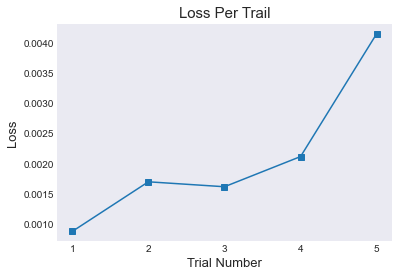

In [74]:
plt.plot(loss, marker="s")

plt.title("Loss Per Trail", size=15)
plt.xlabel("Trial Number", size=13)
plt.ylabel("Loss", size=13)
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])

# save the fig
plt.savefig(r'C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\figs\LossTrial.png')

plt.show()

# Export 500 genes

In [76]:
len(top_genes)

500

In [77]:
exportGenes_df = pd.DataFrame(top_genes)
exportGenes_df.head()

,0
0,FRY
1,TXNIP
2,FRY
3,LRRN4
4,LRRN4


In [79]:
exportGenes_df.to_csv(r'C:\Users\noahb\OneDrive\Documents\Tensorflow_Tutorial\mini_project\topGenes.csv', index=True)